#             Unsupervised Learning: Clustering & Profiling

## Model  By Alisha

# 1️⃣ Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


# 2️⃣ Load Dataset

In [5]:
df = pd.read_csv("online_retail.csv")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 3️⃣ Data Understanding & EDA

## Dataset Overview

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Missing Values

In [7]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Clean Dataset

In [8]:
df = df.dropna()
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]


# 4️⃣ Feature Engineering (Customer-Level Data)

In [9]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

customer_df.columns = [
    'CustomerID',
    'NumInvoices',
    'TotalQuantity',
    'TotalSpend'
]

customer_df.head()


,CustomerID,NumInvoices,TotalQuantity,TotalSpend
0,12346.0,1,74215,77183.60
1,12347.0,7,2458,4310.00
2,12348.0,4,2341,1797.24
3,12349.0,1,631,1757.55
4,12350.0,1,197,334.40


# 5️⃣ EDA Visualizations

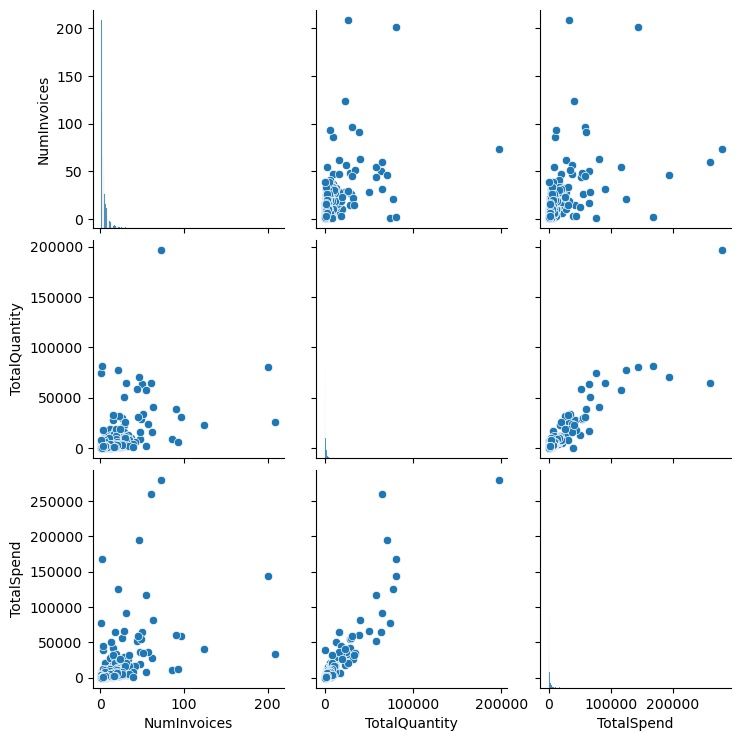

In [33]:
sns.pairplot(
    customer_df[['NumInvoices','TotalQuantity','TotalSpend']]
)
plt.show()

# 6️⃣ Data Preprocessing (Scaling)

In [11]:
X = customer_df[['NumInvoices','TotalQuantity','TotalSpend']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 7️⃣ Model Selection — Elbow Method (KMeans)

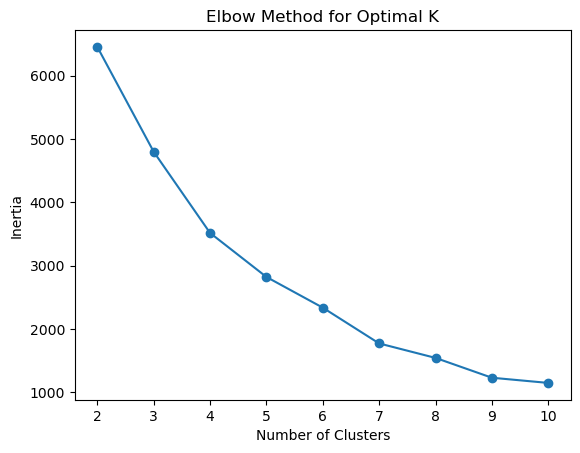

In [12]:
inertia = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


# 8️⃣ Train KMeans Model

In [13]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

customer_df['Cluster'] = kmeans_labels

# 9️⃣ Model Evaluation — Silhouette Score

In [14]:
sil_score = silhouette_score(X_scaled, kmeans_labels)
print("Silhouette Score:", sil_score)


Silhouette Score: 0.7934370926198842


# 🔟 Alternative Clustering Models

## 🔹 DBSCAN

In [15]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)


## 🔹 Hierarchical Clustering

In [16]:
hc = AgglomerativeClustering(n_clusters=4)
hc_labels = hc.fit_predict(X_scaled)


In [34]:
print("KMeans :",silhouette_score(X_scaled,kmeans_labels))
print("Hierarchial :",silhouette_score(X_scaled,hc_labels))

KMeans : 0.7934370926198842
Hierarchial : 0.7164925357541574


# 1️⃣1️⃣ Dimensionality Reduction — PCA (2D)

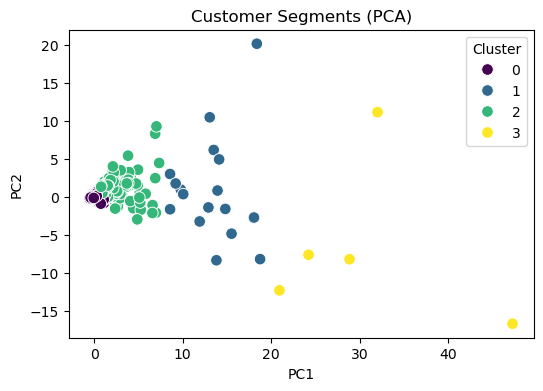

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=customer_df['Cluster'],
    palette='viridis',
    s=70
)
plt.title("Customer Segments (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


#  1️⃣2️⃣ t-SNE Visualization (Better Separation)

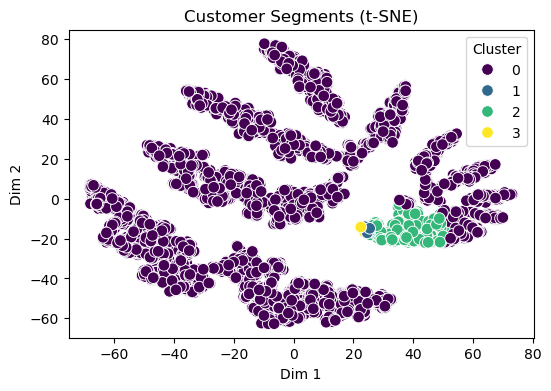

In [19]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=customer_df['Cluster'],
    palette='viridis',
    s=70
)
plt.title("Customer Segments (t-SNE)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Cluster")
plt.show()


# 1️⃣3️⃣ UMAP Visualization (Customer Segmentation)

In [20]:
pip install umap-learn


Note: you may need to restart the kernel to use updated packages.


In [21]:
import umap

C:\Users\Alisha\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


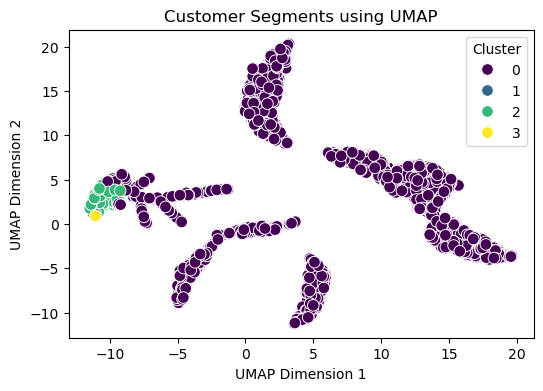

In [35]:
#Apply UMAP on Scaled Data
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
X_umap = umap_model.fit_transform(X_scaled)
#UMAP Cluster Visualization
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=customer_df['Cluster'],
    palette='viridis',
    s=70
)

plt.title("Customer Segments using UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()


# 1️⃣4️⃣ Compare PCA vs UMAP

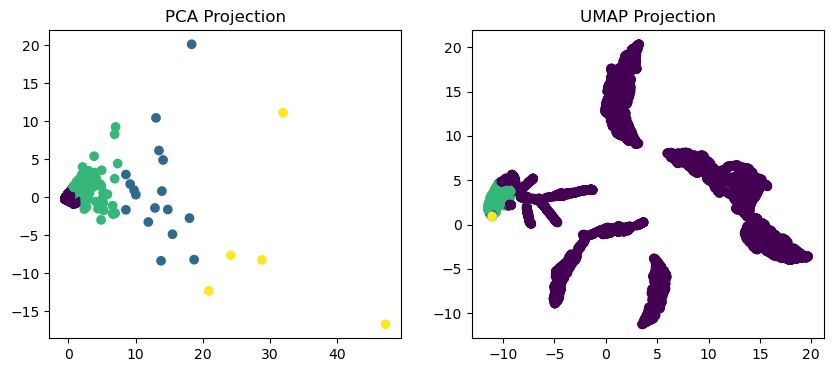

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# PCA
axes[0].scatter(X_pca[:,0], X_pca[:,1], c=customer_df['Cluster'], cmap='viridis')
axes[0].set_title("PCA Projection")

# UMAP
axes[1].scatter(X_umap[:,0], X_umap[:,1], c=customer_df['Cluster'], cmap='viridis')
axes[1].set_title("UMAP Projection")

plt.show()


# 1️⃣5️⃣ Cluster Centers (Original Scale)

In [24]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = pd.DataFrame(
    centers,
    columns=['NumInvoices','TotalQuantity','TotalSpend']
)

cluster_centers


,NumInvoices,TotalQuantity,TotalSpend
0,2.970341,622.759021,1046.615703
1,61.235294,44177.235294,65307.416471
2,18.855556,5203.044444,9332.826000
3,76.400000,98458.800000,209342.334000


# 1️⃣6️⃣ Cluster Profiling

In [25]:
cluster_profile = customer_df.groupby('Cluster').mean()
cluster_profile


,CustomerID,NumInvoices,TotalQuantity,TotalSpend
Cluster,,,,
0,15302.539565,2.966123,621.738625,1045.100231
1,15007.117647,61.235294,44177.235294,65307.416471
2,15268.470588,18.801471,5184.536765,9294.429485
3,16311.000000,76.400000,98458.800000,209342.334000


# 1️⃣7️⃣Cluster Profile Heatmap

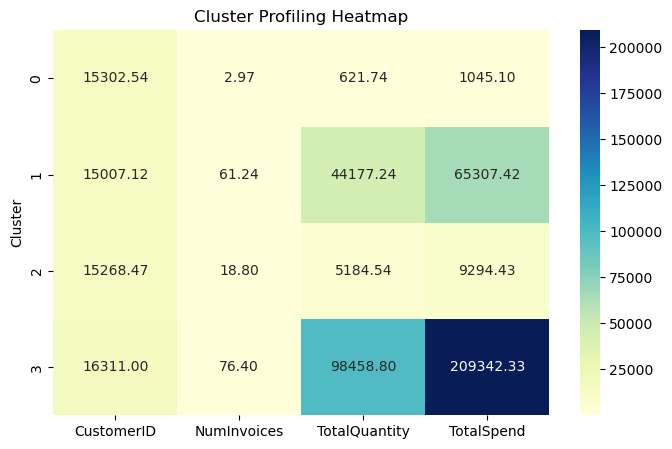

In [26]:
plt.figure(figsize=(8,5))
sns.heatmap(
    cluster_profile,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title("Cluster Profiling Heatmap")
plt.show()
